In [110]:
import numpy as np
import pandas as pd
from IPython.display import display
from tqdm import tqdm
from collections import Counter
import ast
import re

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sb

from sklearn.feature_extraction.text import CountVectorizer
from textblob import TextBlob
import scipy.stats as stats

from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation


from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
output_notebook()

%matplotlib inline

Loading BokehJS ...

In [111]:
df = pd.read_csv('Combined_News_DJIA.csv', parse_dates=[0], infer_datetime_format=True)
df.head()

Date  Label                                               Top1  \
0 2008-08-08      0  b"Georgia 'downs two Russian warplanes' as cou...   
1 2008-08-11      1  b'Why wont America and Nato help us? If they w...   
2 2008-08-12      0  b'Remember that adorable 9-year-old who sang a...   
3 2008-08-13      0  b' U.S. refuses Israel weapons to attack Iran:...   
4 2008-08-14      1  b'All the experts admit that we should legalis...   

                                                Top2  \
0            b'BREAKING: Musharraf to be impeached.'   
1        b'Bush puts foot down on Georgian conflict'   
2                 b"Russia 'ends Georgia operation'"   
3  b"When the president ordered to attack Tskhinv...   
4  b'War in South Osetia - 89 pictures made by a ...   

                                                Top3  \
0  b'Russia Today: Columns of troops roll into So...   
1  b"Jewish Georgian minister: Thanks to Israeli ...   
2  b'"If we had no sexual harassment we would hav...   
3  b' Israel clears troops who killed Reuters cam...   
4  b'Swedish wrestler Ara Abrahamian throws away ...   

                                                Top4  \
0  b'Russian tanks are moving towards the capital...   
1  b'Georgian army flees in disarray as Russians ...   
2  b"Al-Qa'eda is losing support in Iraq because ...   
3  b'Britain\'s policy of being tough on drugs is...   
4  b'Russia exaggerated the death toll in South O...   

                                                Top5  \
0  b"Afghan children raped with 'impunity,' U.N. ...   
1      b"Olympic opening ceremony fireworks 'faked'"   
2  b'Ceasefire in Georgia: Putin Outmaneuvers the...   
3  b'Body of 14 year old found in trunk; Latest (...   
4  b'Missile That Killed 9 Inside Pakistan May Ha...   

                                                Top6  \
0  b'150 Russian tanks have entered South Ossetia...   
1  b'What were the Mossad with fraudulent New Zea...   
2  b'Why Microsoft and Intel tried to kill the XO...   
3  b'China has moved 10 *million* quake survivors...   
4  b"Rushdie Condemns Random House's Refusal to P...   

                                                Top7  \
0  b"Breaking: Georgia invades South Ossetia, Rus...   
1  b'Russia angered by Israeli military sale to G...   
2  b'Stratfor: The Russo-Georgian War and the Bal...   
3  b"Bush announces Operation Get All Up In Russi...   
4  b'Poland and US agree to missle defense deal. ...   

                                                Top8  ...  \
0  b"The 'enemy combatent' trials are nothing but...  ...   
1  b'An American citizen living in S.Ossetia blam...  ...   
2  b"I'm Trying to Get a Sense of This Whole Geor...  ...   
3             b'Russian forces sink Georgian ships '  ...   
4  b'Will the Russians conquer Tblisi? Bet on it,...  ...   

                                               Top16  \
0  b'Georgia Invades South Ossetia - if Russia ge...   
1  b'Israel and the US behind the Georgian aggres...   
2  b'U.S. troops still in Georgia (did you know t...   
3                      b'Elephants extinct by 2020?'   
4  b'Bank analyst forecast Georgian crisis 2 days...   

                                               Top17  \
0                b'Al-Qaeda Faces Islamist Backlash'   
1  b'"Do not believe TV, neither Russian nor Geor...   
2       b'Why Russias response to Georgia was right'   
3  b'US humanitarian missions soon in Georgia - i...   
4  b"Georgia confict could set back Russia's US r...   

                                               Top18  \
0  b'Condoleezza Rice: "The US would not act to p...   
1  b'Riots are still going on in Montreal (Canada...   
2  b'Gorbachev accuses U.S. of making a "serious ...   
3             b"Georgia's DDOS came from US sources"   
4  b'War in the Caucasus is as much the product o...   

                                               Top19  \
0  b'This is a busy day:  The European Union has ...   
1    b'China to overtake US as largest manufacturer

In [112]:
data = []
for row in range(0,len(df.index)):
    data.append(' '.join(str(x) for x in df.iloc[row,2:27]))
    

In [113]:
data = [re.sub("b\'", '', doc) for doc in data]

data = [re.sub("\'", '', doc) for doc in data]

data = [re.sub("b", '', doc) for doc in data]

In [114]:
df_date = []
for i in df['Date']:
    df_date.append(i)

date = pd.DataFrame(df_date, columns=['Date'])
text = pd.DataFrame(data, columns=['Text'])

#text.index = date
df2 = date.join(text)
new_df = df2['Text']
new_df.index = df2['Date']

In [ ]:
for i in data:
    print(len(i))

In [280]:
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 
import nltk
nltk.download('wordnet')
from nltk.corpus import wordnet

class LemmaTokenizer(object):
    def __init__(self):
        self.lemma = WordNetLemmatizer()
    def __call__(self, articles):
            token = [self.lemma.lemmatize(t) for t in word_tokenize(articles)]        
            return token
#call_token(data)

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\chide\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [286]:
def get_top_n_words( count_vectorizer, n_top_words, text_data):
    '''
    returns a tuple of the top n words in a sample and their 
    accompanying counts, given a CountVectorizer object and text sample
    '''
    vectorized_headlines = count_vectorizer.fit_transform(text_data.values)
    print(vectorized_headlines)
    #vectorized_headlines = count_vectorizer.fit_transform(text_data.values)
    vectorized_total = np.sum(vectorized_headlines, axis=0)
    word_indices = np.flip(np.argsort(vectorized_total)[0,:], 1)
    word_values = np.flip(np.sort(vectorized_total)[0,:],1)
    
    word_vectors = np.zeros((n_top_words, vectorized_headlines.shape[1]))
    for i in range(n_top_words):
        word_vectors[i,word_indices[0,i]] = 1

    words = [word[0].encode('ascii').decode('utf-8') for 
             word in count_vectorizer.inverse_transform(word_vectors)]

    return (words, word_values[0,:n_top_words].tolist()[0])

In [300]:
token = LemmaTokenizer()
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'say', 'first', 'make', 'take'])

tf_vectorizer = CountVectorizer(tokenizer=token,
                       stop_words = stop_words,
                       lowercase = True,
                       max_df = 0.5,
                       min_df = 10)

words, word_values = get_top_n_words(tf_vectorizer,n_top_words=15,text_data=new_df)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\chide\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
C:\Users\chide\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'re", "'s", "'ve", 'could', 'doe', 'ha', 'might', 'must', "n't", 'need', 'sha', 'wa', 'wo', 'would'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


  (0, 2660)	10
  (0, 6334)	2
  (0, 5275)	5
  (0, 6615)	1
  (0, 3993)	1
  (0, 5188)	1
  (0, 902)	2
  (0, 5274)	4
  (0, 6160)	2
  (0, 1243)	1
  (0, 6286)	2
  (0, 5223)	1
  (0, 5668)	7
  (0, 4290)	7
  (0, 2511)	1
  (0, 2423)	1
  (0, 5)	1
  (0, 6803)	1
  (0, 6)	1
  (0, 6023)	2
  (0, 3997)	1
  (0, 6205)	1
  (0, 987)	2
  (0, 5066)	1
  (0, 1289)	1
  :	:
  (1988, 5472)	1
  (1988, 1528)	1
  (1988, 3922)	1
  (1988, 558)	1
  (1988, 47)	1
  (1988, 6510)	1
  (1988, 5298)	1
  (1988, 5518)	1
  (1988, 4030)	1
  (1988, 312)	1
  (1988, 5082)	1
  (1988, 4742)	1
  (1988, 3505)	1
  (1988, 5189)	1
  (1988, 4915)	1
  (1988, 1068)	1
  (1988, 6011)	1
  (1988, 6644)	1
  (1988, 5899)	1
  (1988, 1819)	1
  (1988, 210)	1
  (1988, 530)	1
  (1988, 2338)	1
  (1988, 5709)	1
  (1988, 1868)	1


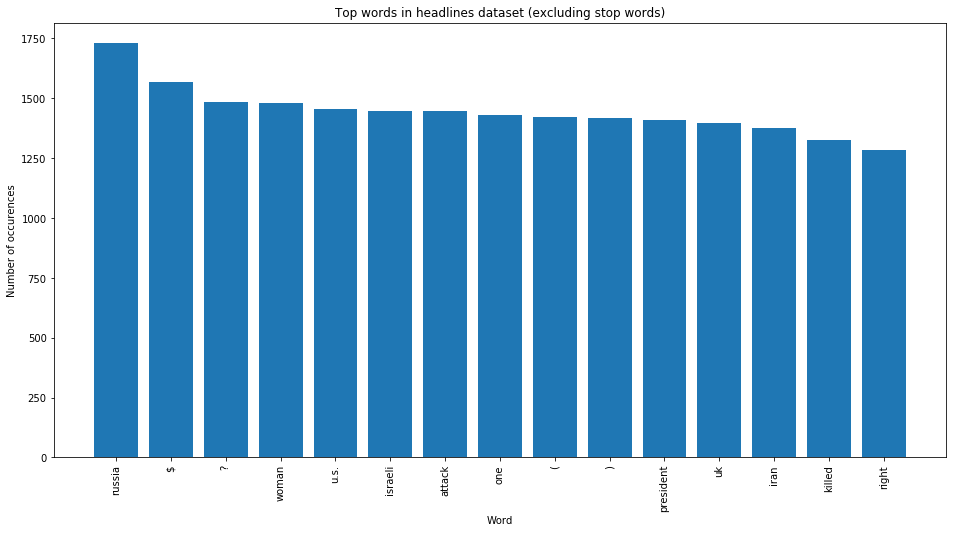

In [299]:
fig, ax = plt.subplots(figsize=(16,8))
ax.bar(range(len(words)), word_values);
ax.set_xticks(range(len(words)));
ax.set_xticklabels(words, rotation='vertical');
ax.set_title('Top words in headlines dataset (excluding stop words)');
ax.set_xlabel('Word');
ax.set_ylabel('Number of occurences');
plt.show()

In [94]:
tagged_headlines = [TextBlob(new_df[i]).pos_tags for i in range(new_df.shape[0])]

In [95]:
tagged_headlines_df = pd.DataFrame({'tags':tagged_headlines})

word_counts = [] 
pos_counts = {}

for headline in tagged_headlines_df[u'tags']:
    word_counts.append(len(headline))
    for tag in headline:
        if tag[1] in pos_counts:
            pos_counts[tag[1]] += 1
        else:
            pos_counts[tag[1]] = 1
            
print('Total number of words: ', np.sum(word_counts))
print('Mean number of words per headline: ', np.mean(word_counts))

Total number of words:  876578
Mean number of words per headline:  440.71292106586225


C:\Users\chide\anaconda3\lib\site-packages\numpy\lib\histograms.py:908: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


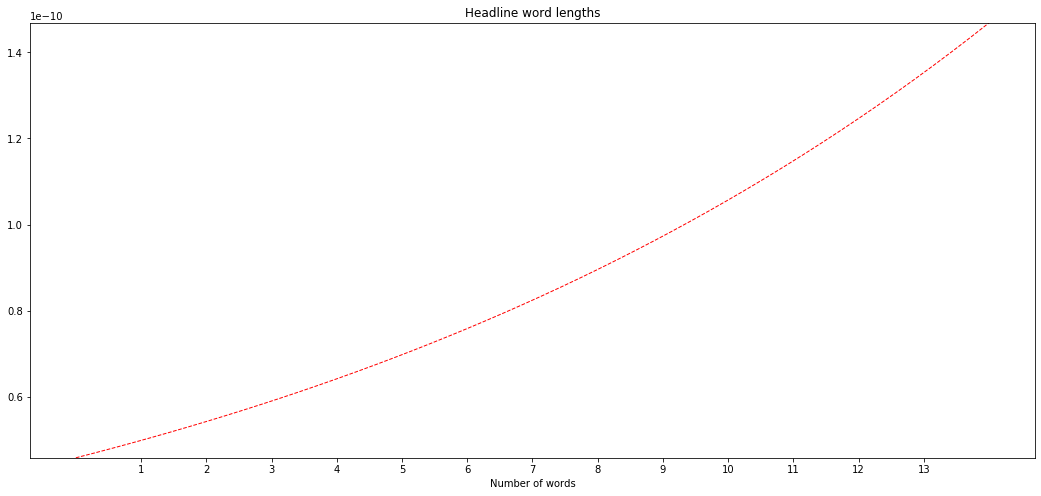

In [96]:
y = stats.norm.pdf(np.linspace(0,14,50), np.mean(word_counts), np.std(word_counts))

fig, ax = plt.subplots(figsize=(18,8))
ax.hist(word_counts, bins=range(1,14), density=True);
ax.plot(np.linspace(0,14,50), y, 'r--', linewidth=1);
ax.set_title('Headline word lengths');
ax.set_xticks(range(1,14));
ax.set_xlabel('Number of words');
plt.show()